In [ ]:
# In colab run this cell first to setup the file structure!
%cd /content
!rm -rf MOL518-Intro-to-Data-Analysis

!git clone https://github.com/shaevitz/MOL518-Intro-to-Data-Analysis.git
%cd MOL518-Intro-to-Data-Analysis/Precept_4

[Errno 2] No such file or directory: '/content'
/Users/bg0729/Documents/MOL518-precepts/MOL518-Intro-to-Data-Analysis/Precept_4
Cloning into 'MOL518-Intro-to-Data-Analysis'...
remote: Enumerating objects: 1011, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 1011 (delta 167), reused 132 (delta 107), pack-reused 745 (from 1)
Receiving objects: 100% (1011/1011), 32.33 MiB | 8.38 MiB/s, done.
Resolving deltas: 100% (417/417), done.
/Users/bg0729/Documents/MOL518-precepts/MOL518-Intro-to-Data-Analysis/Precept_4/MOL518-Intro-to-Data-Analysis/Precept_3


# Hypothesis testing for empirical distributions

In this precept, we will use a real dataset to explore concepts you've learned in class relating to random waiting times and statistical hypothesis testing.

## The exponential random distribution and waiting times

When a random event occurs at a constant rate $\lambda$ per unit time, the waiting time for an event occurence is an exponential random variable: the probability of a wait time $T$ exceeding a given threshold decays exponentially in the threshold, i.e.

$$ P[T > t] = \exp(-\lambda t). $$

From this, it can be shown that the mean and standard deviation of the waiting time are $E[T] = \sigma_T = \lambda^{-1}$.

## Counting earthquakes in California

### Background

![san_andreas_fault](figs/san_andreas_fault.png)

Suppose you decide to spend your vacation in California, so you sit in a cafe and note down when earthquakes happen. If you do this exercise, you will notice that earthquakes are, in multiple ways, random events: they occur at unpredictable times and have unpredictable strengths (say in terms of how much shaking you observe). 

Modern geophysics gives us a clear idea as to why earthquakes happen: the solid ground we sit on (the Earth's outer layer, called the lithosphere) is actually made up of disjoint tectonic plates that fit together like puzzle pieces sitting atop a ductile (in some ways fluid-like) mantle. Since these pieces are being advected by the mantle in different directions, stress tends to build up at the boundaries between plates. When this stress is released, part of the energy is dissipated into acoustic waves, and the ground itself shakes. 

While this is verbally simple enough, earthquakes are unpredictable, owing among other reasons to the complex geometry of plate contact and the non-linear dynamics of stress transfer between plates.

### Loading the dataset

In data/earthquake.csv, you can find a dataset of timestamps of magnitude 3+ earthquakes in the vicinity of the state of California (see supplement for more information on this particular data). This dataset is a csv table with two columns: time, giving a series of timestamps in seconds, and magnitude, which gives the magnitude of the earthquake on the Richter scale.

In [2]:
import numpy as np

In [3]:
# we read in the earthquake.csv file
all_data = np.genfromtxt('data/earthquake.csv', delimiter=',', skip_header=True)
timestamps = all_data[:, 0]
magnitudes = all_data[:, 1]

### Example 1: Gutenberg-Richter law

According to the Gutenberg-Richter (GR) law, the number of earthquakes above a given magnitude $m = m_0 + \Delta m$, where $m_0$ is a minimum detection threshold, decays exponentially relative to the threshold. As an aside, this has nothing to do with the constant rate assumptions underlying exponential distributions of waiting times, and reflects a power-law behavior in the distribution of radiated energy of an earthquake. Nevertheless, in terms of an occurence with random magnitude $M$, we can write, as per the intro, an exponential law:

$$ P[M - m_0 > \Delta m] = \exp(- b \;\Delta m),$$

where $b$ here is a rate parameter associated to earthquake magnitude. Let's see whether this law can be verified in our dataset

Mean shifted magnitude: 0.54
Standard deviation of magnitude: 0.56
CV of earthquake magnitude: 1.03


Text(0, 0.5, 'Density')

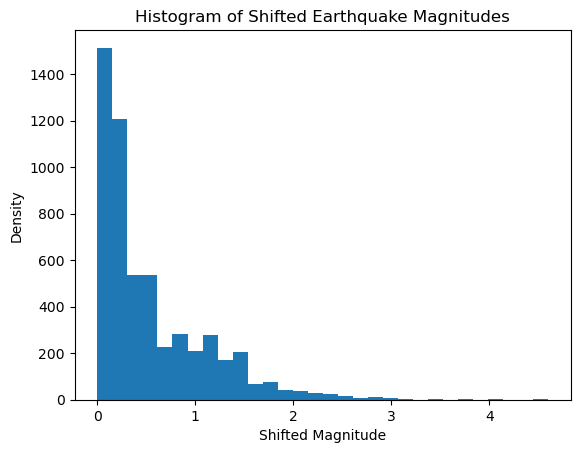

In [5]:
# As noted in the intro, in an exponentially distributed random variable, the mean is equal to the standard deviation. 
# We can check this for our earthquake magnitudes.
# First, we shift the magnitudes relative to the minimum we defined above, which is 3.
magnitude_shifted = magnitudes - magnitudes.min()
# From this dataset, we can estimate the mean and standard deviation of the magnitudes.
mean_magnitude = np.mean(magnitude_shifted)
std_magnitude = np.std(magnitudes)
# Now we print out these estimates with two digit precision
print(f'Mean shifted magnitude: {mean_magnitude:.2f}')
print(f'Standard deviation of magnitude: {std_magnitude:.2f}')
print(f'CV of earthquake magnitude: {std_magnitude / mean_magnitude:.2f}')

# Now we plot the histogram of the shifted magnitudes
import matplotlib.pyplot as plt
plt.hist(magnitude_shifted, bins=30)
plt.title('Histogram of Shifted Earthquake Magnitudes')
plt.xlabel('Shifted Magnitude')
plt.ylabel('Density')

Does this look like an exponential distribution? How accurate is our estimate of the mean and standard deviation from the above dataset? Would the result above satisfactorily answer whether the GR law is observed in the dataset?

### Interlude: the Kolmogorov-Smirnov test statistic

As we discussed in class, a more rigorous way to go about this is to test the hypothesis that our data obeys the GR law by defining a $p$-value, for which we need two things: first a test statistic $D$, which is a real-valued function over the space of our data. Second, we need an estimate of the distribution of $D$ under a null-hypothesis $H_0$, our baseline probability distribution for the data. Crucially, since $D$ is real-valued, we can exploit the ordering of the real numbers to define a single probability that encapsulates how likely of an outlier our observations are under the null-hypothesis, $p = P_{H_0}[D > \hat{D}(\mathrm{Data})]$.

For an arbitrary empirical one-dimensional probability distribution, a test statistic we can define is called the **Kolmogorov-Smirnov statistic**. It can be defined in terms of the **complementary cumulative distribution function** (CCDF), $\tilde{F}$, which for a random variable $X$ is a function we have been already a lot implicitly, namely $$\tilde{F}(x) = P[X > x].$$ 
An estimator for the CDF is constructed by simply counting the proportion of observations above a value, i.e.,
$$\hat{\tilde{F}}(x) = \frac{\#(\mathrm{Data} > x)}{\#(\mathrm{Data})}.$$
Then, we can define the Kolmogorov-Smirnov (KS) statistic $D$ as the largest deviation of $\hat{\tilde F}$ from $\tilde{F}$ under the null hypothesis,
$$D = \max_{x \in \mathrm{Data}} | \tilde{F}(x | H_0) - \hat{\tilde{F}}(x)|.$$

**Take the time to convince yourself that this has all the properties we would expect from a test statistic.** Now we are going to define below these functions in Python.

In [ ]:
# We define the CCDF of an exponential distribution as per above.
def exponential_ccdf(x, rate):
    return np.exp(-rate * x)

def empirical_ccdf(data):
    # Why does this simple snippet compute the empirical CCDF?
    # Remember this is the image of the CCDF, not its domain values, which are the sorted data.
    # Convince yourself this is correct! 
    n = len(data)
    return 1 - np.arange(1, n + 1) / n 

def exponential_ks_statistic(data, rate):
    sorted_data = np.sort(data)
    # Explicitly compute the KS statistic
    ks_statistic = np.max(np.abs(empirical_ccdf(data) - exponential_ccdf(sorted_data, rate)))
    
    return ks_statistic

PS: most sources are going to define this in terms of the cumulative distribution function (CDF), $F = 1 - \tilde{F}$, but the math ends up being the same.

### Example 2: Parametric bootstrapping and a p-value for the GR hypothesis

If we are happy with the Kolmogorov-Smirnov statistic $D$, all that remains is to compute what its expected distribution would be under the GR law, which we take to be our null hypothesis, to get a p-value. Indeed, this itself presents some challenges: (i) the GR law still doesn't satisfy our definition of a null-hypothesis, since all it specifies is a parametric family of distributions as a function of the rate $b$. (ii) Even if we know $b$, we don't know of a closed form for the distribution of the KS statistic of $5497$ independent identical realizations of the same exponential law. Are we doomed? 

Here we can employ a bootstrapping procedure. As you saw in class, bootstrapping involves getting more data out of your data. In our case, we can estimate the relevant rate parameter, which under the null hypothesis is nothing but $\hat{b} = 1 / \bar{M}$. If we are satisfied with this estimate, we can now simulate a bunch of exponentially distributed data with rate $\hat{b}$ and compute the empirical distribution of the $KS$ statistic under this simulated data, $D^*$, to compare with our observed $KS$ statistic, $\hat D$. This is called **parametric bootstrapping**, it is a self-consistent way to use an estimated distribution to validate the estimate of that distribution. Just like the $CCDF$, we can now compute the $p$-value under $R$ realizations of bootstrapping as

$$p = \frac{\#(D^* > D)}{R}$$

In [ ]:
# First we compute the estimated rate parameter for the exponential distribution, which is the inverse of the mean.
empirical_rate = 1 / mean_magnitude 
# We compute the KS statistic for our data and the exponential distribution with this rate parameter.
ks_statistic = exponential_ks_statistic(magnitude_shifted, empirical_rate)
print(f'KS statistic for earthquake magnitudes: {ks_statistic:.4f}')

# Now the parametric bootstrap procedure to compute a p-value for the KS statistic.
R = 1000 # number of bootstrap realizations
bootstrap_ks_statistics = np.zeros(R)
for i in range(R):
    # We generate a bootstrap sample from the exponential distribution with the estimated rate parameter.
    # Just note that np.random_exponential takes the scale parameter, which is the inverse of the rate parameter.
    bootstrap_sample = np.random.exponential(scale=1/empirical_rate, size=len(magnitude_shifted))
    # We compute the KS statistic for this bootstrap sample.
    bootstrap_ks_statistics[i] = exponential_ks_statistic(bootstrap_sample, empirical_rate)
# Finally, we compute the p-value as defined above,
p = (1 + np.sum(bootstrap_ks_statistics >= ks_statistic)) / (1+R)
print(f'Bootstrap p-value for KS statistic: {p:2f}')

This should make the GR hypothesis look pretty dire! Why is our p-value based hypothesis testing rejecting it so strongly? Let's do an obvious sanity check we could have done from the start: looking at the CCDF in log-scale

In [ ]:
# Now we plot the empirical CCDF of the shifted magnitudes and the CCDF of the exponential distribution with the estimated rate parameter.
x = np.linspace(0, magnitude_shifted.max(), 100)
plt.plot(x, exponential_ccdf(x, empirical_rate), label='Exponential CCDF', color='orange', linestyle='--')
plt.plot(np.sort(magnitude_shifted), empirical_ccdf(magnitude_shifted), label='Empirical CCDF')
plt.yscale('log')

### Exercise: saving the GR law

From the plot above, why do you think the exponential hypothesis is being rejected? Is there a subset of the data for which it should hold? If so, verify it.

# Bonus exercise: The distribution of times between earthquakes

A harder problem (which starts to touch the complicated geophysics of earthquakes) is to consider the inter-arrival time of earthquakes. Now, if earthquakes were to happen at a constant rate $\lambda$, we would expect these arrival times to behave a lot like the an exponential.

To compute the intervals between events, we can use the diff function in numpy, which creates an array of successive differences of different arrays. For example, I compute below the total observed intervals between earthquakes in our dataset, in days

In [33]:
intervals = np.diff(timestamps)/(60*60*24) # convert to days

Play around with the above data. Does it look exponential? How non-exponential is it, is it worse than the GR case above? How does it fare under hypothesis testing?